In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import joblib

In [2]:
def load_data(data_dir):
    data = []
    labels = []
    for label, class_name in enumerate(['ripe', 'unripe']):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(class_dir, filename)
                csv_data = pd.read_csv(file_path).values.flatten()
                data.append(csv_data)
                labels.append(label)
    return np.array(data), np.array(labels)

In [3]:
data_dir = 'dataset'
data, labels = load_data(data_dir)
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
# Menyimpan scaler ke file
scaler_file = "scaler.pkl"
joblib.dump(scaler, scaler_file)
max_len = max(map(len, data))
data = np.array([np.pad(d, (0, max_len - len(d)), 'constant') for d in data])

In [4]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               9

In [5]:
data = data.reshape((data.shape[0], data.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2/2 [==============================] - 2s 317ms/step - loss: 0.6861 - accuracy: 0.5167 - val_loss: 0.6915 - val_accuracy: 0.4375
Epoch 2/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6730 - accuracy: 0.5167 - val_loss: 0.6947 - val_accuracy: 0.4375
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6572 - accuracy: 0.5167 - val_loss: 0.6955 - val_accuracy: 0.4375
Epoch 4/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6329 - accuracy: 0.5167 - val_loss: 0.6995 - val_accuracy: 0.4375
Epoch 5/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6093 - accuracy: 0.5500 - val_loss: 0.7021 - val_accuracy: 0.4375
Epoch 6/100
2/2 [==============================] - 0s 53ms/step - loss: 0.6137 - accuracy: 0.5500 - val_loss: 0.6995 - val_accuracy: 0.4375
Epoch 7/100
2/2 [==============================] - 0s 75ms/step - loss: 0.5833 - accuracy: 0.5833 - val_loss: 0.6958 - val_accuracy: 0.4375
Epoch 8/100
2/2 [==

In [6]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

1/1 [==============================] - 0s 21ms/step - loss: 0.2559 - accuracy: 0.9474
Test Accuracy: 94.74%


In [7]:
predictions = model.predict(X_test)
predictions = np.round(predictions).flatten()
predictions

1/1 [==============================] - 0s 204ms/step


array([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

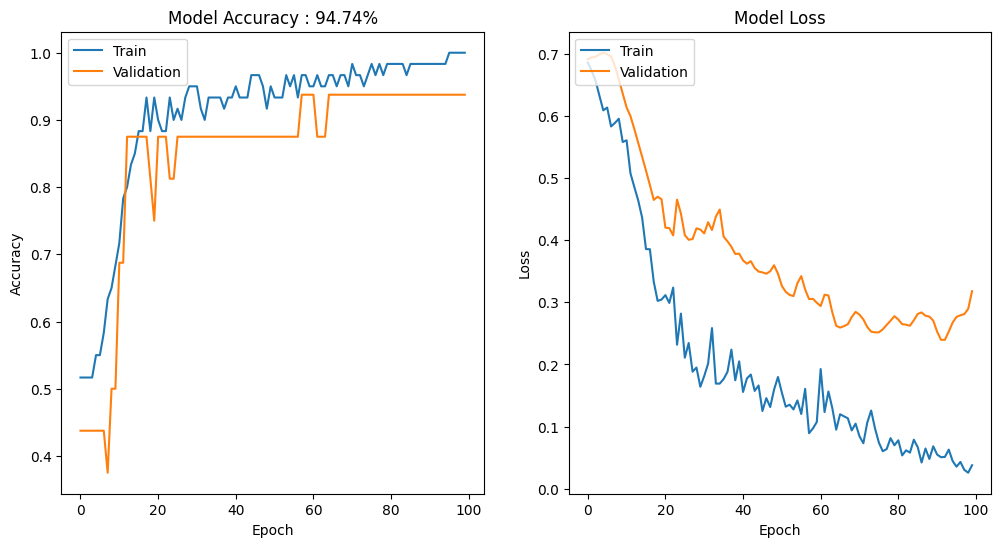

In [8]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Add validation accuracy
plt.title(f'Model Accuracy : {accuracy*100:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

# Save the plot with the specified name format
plt.savefig(f"hasil training/{date_time_str}.png")
plt.show()

1/1 [==============================] - 0s 35ms/step


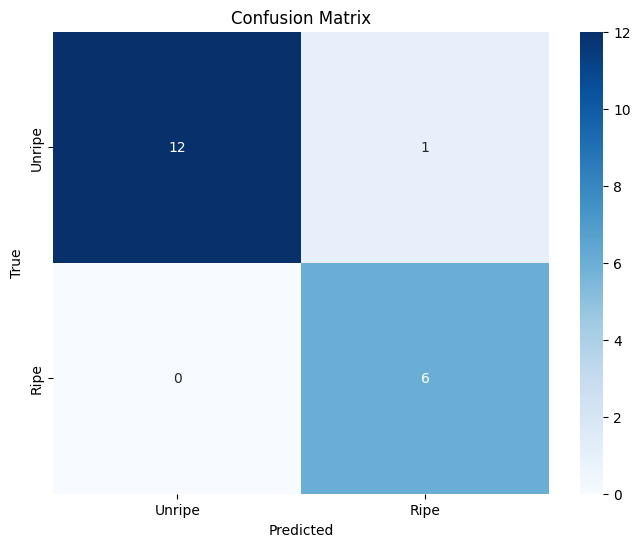

In [9]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# save model to .keras file
now = datetime.datetime.now()
# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")
model.save(f"{date_time_str}.keras")